In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from adaptnn.visual_neuron_convnets import PopulationFullFieldNet, SpatioTemporalRFConv3D, penalize_convnet_weights
torch.set_default_device('cuda:0')


/tmp/ipykernel_376827/447440598.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cs[c_num] = c[0] + np.log(dt*12)


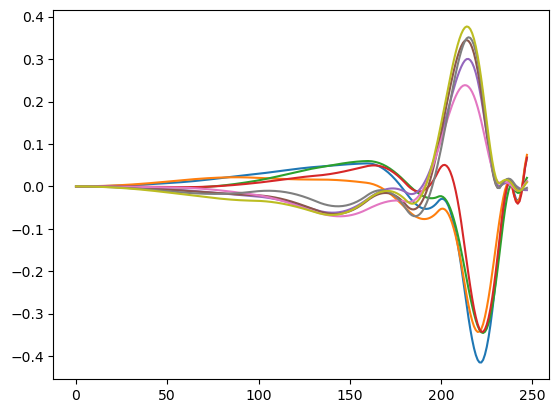

In [2]:
# load GLM filters from CBEM paper fits
filter_ms = np.zeros((248,9))
cs = np.zeros(9)
for c_num in range(9):
    f = h5py.File(f"/media/latimerk/ExtraDrive1/cbem/Results/JN05/GLM/GLM_{c_num+1}.mat", 'r')
    k_stim = np.array(f['GLM']['k_stim']) # stimBasisVectors
    basis  = np.array(f['GLM']['stimBasisVectors']) 
    c = np.array(f['GLM']['b']).ravel()
    dt = np.array(f['GLM']['dt']) 

    filter = (k_stim @ basis).ravel()
    filter_ms[:,c_num] = filter[::12]*8
    cs[c_num] = c[0] + np.log(dt*12)

filter_ms = np.array(np.flip(filter_ms,axis=0))
plt.plot(filter_ms);


Text(0.5, 1.0, 'spike rates')

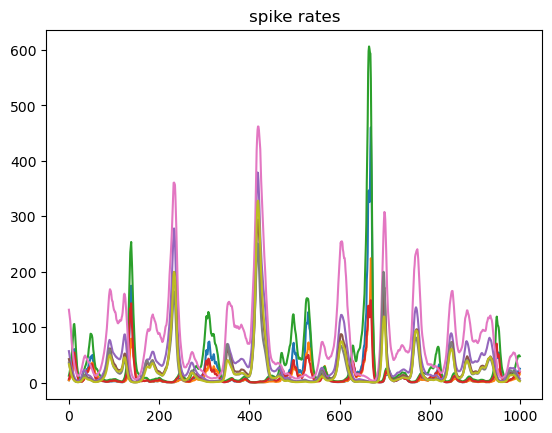

In [3]:
T = int(60e3 * 5 + 247) # 5 minutes of data
# simulate spikes: no spk history
sim_layer = torch.nn.Conv1d(in_channels=1,out_channels=filter_ms.shape[1],kernel_size=filter_ms.shape[0],stride=1,padding='valid')
with torch.no_grad():
    for ii in range(sim_layer.out_channels):
        sim_layer.weight[ii,0][:] = torch.Tensor(filter_ms[:,ii]);
        sim_layer.bias[ii] = cs[ii]

    X_sim_0 = torch.randn((1,T))
    Y_sim = sim_layer(X_sim_0)
    spks_per_bin_sim = torch.exp(Y_sim)

    rates = spks_per_bin_sim[:,:1000].cpu().numpy().T*1e3

    spikes_sim = torch.poisson(spks_per_bin_sim)
    spikes_sim[spikes_sim>1] = 1
    spikes_sim_cpu = spikes_sim.cpu().numpy()

    X_sim = X_sim_0[:,247:]
    X_sim_0_cpu = X_sim_0.cpu().numpy()

plt.plot(rates);
plt.title("spike rates")



In [4]:
# fit with NN model
model = PopulationFullFieldNet(num_cells = filter_ms.shape[1], layer_time_lengths=[149,100], out_activation=None)
criterion=torch.nn.PoissonNLLLoss(log_input=True) 

with torch.no_grad():
    print(model(X_sim_0).shape)


torch.Size([9, 300000])


In [8]:

epochs = 10000
learning_rate=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=epochs/2)

penalty_function = lambda : penalize_convnet_weights(model, en_lambda=0.1, en_alpha = 0, fl_lambda_t=0.2, lin_en_alpha=0, lin_en_lambda=0.1)

for epoch in range(epochs):
    
    #convert numpy array to torch Variable
    optimizer.zero_grad()
    
    #Forward to get outputs
    outputs=model(X_sim_0)
    
    #calculate loss
    loss=criterion(outputs, spikes_sim) + penalty_function()
    
    #getting gradients wrt parameters
    loss.backward()
    
    #updating parameters
    optimizer.step()
    scheduler.step()
    
    if((epoch+1) % 100 == 0):
        print(f"epoch {epoch+1}, loss {loss.data}, step size {optimizer.param_groups[0]['lr']}")

epoch 100, loss 0.10926232486963272, step size 0.0984999999999999
epoch 200, loss 0.10902529209852219, step size 0.09699999999999978
epoch 300, loss 0.10881350934505463, step size 0.09549999999999967
epoch 400, loss 0.1086263656616211, step size 0.09399999999999956
epoch 500, loss 0.10845853388309479, step size 0.09249999999999944
epoch 600, loss 0.10830403119325638, step size 0.09099999999999933
epoch 700, loss 0.10816134512424469, step size 0.08949999999999922
epoch 800, loss 0.10803069174289703, step size 0.0879999999999991
epoch 900, loss 0.1079111248254776, step size 0.086499999999999
epoch 1000, loss 0.1077997013926506, step size 0.08499999999999888
epoch 1100, loss 0.10769511759281158, step size 0.08349999999999877
epoch 1200, loss 0.10759805142879486, step size 0.08199999999999866
epoch 1300, loss 0.1075071468949318, step size 0.08049999999999854
epoch 1400, loss 0.10742348432540894, step size 0.07899999999999843
epoch 1500, loss 0.10734492540359497, step size 0.077499999999998

tensor(0.0026, device='cuda:0')


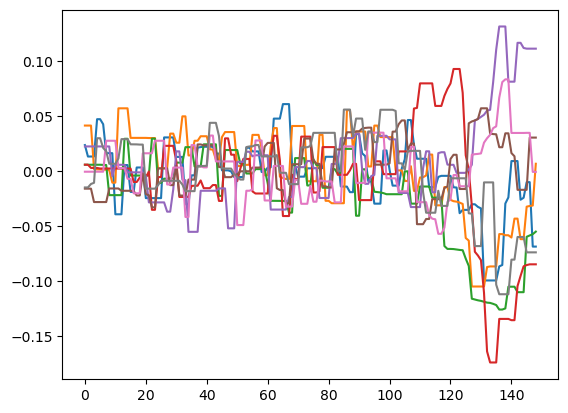

In [7]:
with torch.no_grad():
    print(penalize_convnet_weights(model, en_lambda=0.5, en_alpha = 0.5, fl_lambda_t=0.1))
    W = model[0].weight.cpu().numpy()
    plt.plot(W.squeeze().T)

In [ ]:
with torch.no_grad():
    print(penalize_convnet_weights(model, en_lambda=0.5, en_alpha = 0.5, fl_lambda_t=0.1))
    W = model[0].weight.cpu().numpy()
    plt.plot(W.squeeze().T)

In [ ]:
# simulate from NN model
with torch.no_grad():
    Y_fit = torch.exp(model(X_sim_0))
    spikes_fit = torch.poisson(Y_fit)
    # spikes_fit[spikes_fit>1] = 1
    spikes_fit = spikes_fit.cpu().numpy()



In [ ]:
# get STAs of NN model
print(spikes_fit.shape)
print(X_sim_0_cpu.shape)

# spikes_fit[:,:250] = 0

stas_sim = np.zeros((9,248))
stas = np.zeros((9,248))
for nn in range(9):
    for tt in range(spikes_fit.shape[1]):
        if(spikes_fit[nn,tt] > 0.5):
            k = X_sim_0_cpu[0,tt:tt+248]
            stas[nn,:] += k
        if(spikes_sim_cpu[nn,tt] > 0.5):
            k = X_sim_0_cpu[0,tt:tt+248]
            stas_sim[nn,:] += k


stas /= spikes_fit.sum(axis=1,keepdims=True)
stas_sim /= spikes_sim_cpu.sum(axis=1,keepdims=True)

In [ ]:
# compare STAs to true filters
plt.subplot(1,2,1)
plt.plot(stas_sim.T);
plt.subplot(1,2,2)
plt.plot(stas.T);

In [ ]:
ker_width = 3;
ker_height = 3;
ker_time = 6;
dilation_x = 1;
dilation_y = 1;
bias = True
stride_x = 1;
stride_y = 1

st_rank = 1
out_channels = 9
in_channels  = 1
test_conv = SpatioTemporalRFConv3D(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(ker_width, ker_height, ker_time), rank=2,
                        stride=(stride_x, stride_y, 1), dilation=(dilation_x, dilation_y, 1), bias=bias, padding=0)

test_conv_0 = torch.nn.Conv3d(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(ker_width, ker_height, ker_time),
                        stride=(stride_x, stride_y, 1), dilation=(dilation_x, dilation_y, 1), bias=bias, padding=0)


X_test = torch.randn((2, in_channels, 8,8,200))
print(X_test.shape)

Y_test_0 = test_conv_0(X_test)
print(Y_test_0.shape)

Y_test = test_conv(X_test)
print(Y_test.shape)

In [ ]:
for xx in test_conv.parameters():
    print("here")
    print(xx.shape)

In [ ]:
with torch.no_grad():
    D = torch.abs(test_conv_0.weight)
    print(torch.sum(D))